# 网络的验证

这种验证其实也就有些类似于目标检测的验证了，比分类问题复杂些，通过一些指标而非简单的分类标签来判定真伪。

如果先不看ggcnn中的思路，这块让我来做的话，分析一下，我们得到的网络输出是pos_img,ang_img和width_img，pos_img各点的值可以视作该点可抓不可抓的概率，图像大小为（300，300），太多了，那么我首先可以把最大值的1000个点筛选出来，然后找对对应的angle和width，凭借这三个参数就可以重建出这些点的抓取框，然后计算与真实各框的iou和jaccard指数等，如果都满足标准，就认为这是一次正确的抓取，这次预测也就是正确的了。

那就开整，流程应该是这样的：
- 首先是从网络的输出映射图中反求出各个实际参数代表的抓取框，主要就是要将cos和sin两个图反求出angle。
- 然后要明确一下成功的标准，然后写函数计算这些标准，最后再集成到类或者函数里面，思路还是很明确的。
  - 1.IoU
  - 2.jaccard index

## 1.数据的反求

首先是通过原始的输出映射四张图把数据读出来，这边我们先运行一个训练，得到一下训练输出，然后方便处理

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from cornell_pro import Cornell
from ggcnn import GGCNN

#准备数据集
cornell_data = Cornell('../cornell')
dataset = torch.utils.data.DataLoader(cornell_data,batch_size = 32)

#从数据集中读取一个样本
for x,y,_ in dataset:
    xc = x
    yc = y
    break
    
#实例化一个网络
net = GGCNN(4)

#定义一个优化器
optimizer = optim.Adam(net.parameters())

#为了能够看出效果，就在这个样本上多训练几次，得到一个很擅长这个样本的模型，然后拿它做预测输出

for i in range(50):
    losses = net.compute_loss(xc,yc)
    
    loss = losses['loss']
    print(i,loss)
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()



0 tensor(1.0516, grad_fn=<AddBackward0>)
1 tensor(1.0290, grad_fn=<AddBackward0>)
2 tensor(1.0031, grad_fn=<AddBackward0>)
3 tensor(0.9711, grad_fn=<AddBackward0>)
4 tensor(0.9308, grad_fn=<AddBackward0>)
5 tensor(0.8786, grad_fn=<AddBackward0>)
6 tensor(0.8094, grad_fn=<AddBackward0>)
7 tensor(0.7173, grad_fn=<AddBackward0>)
8 tensor(0.6000, grad_fn=<AddBackward0>)
9 tensor(0.4665, grad_fn=<AddBackward0>)
10 tensor(0.3270, grad_fn=<AddBackward0>)
11 tensor(0.2301, grad_fn=<AddBackward0>)
12 tensor(0.2672, grad_fn=<AddBackward0>)
13 tensor(0.2872, grad_fn=<AddBackward0>)
14 tensor(0.2127, grad_fn=<AddBackward0>)
15 tensor(0.1375, grad_fn=<AddBackward0>)
16 tensor(0.1060, grad_fn=<AddBackward0>)
17 tensor(0.1083, grad_fn=<AddBackward0>)
18 tensor(0.1209, grad_fn=<AddBackward0>)
19 tensor(0.1285, grad_fn=<AddBackward0>)
20 tensor(0.1266, grad_fn=<AddBackward0>)
21 tensor(0.1168, grad_fn=<AddBackward0>)
22 tensor(0.1047, grad_fn=<AddBackward0>)
23 tensor(0.0989, grad_fn=<AddBackward0>)
24

In [2]:
#将输入传递到网络并计算输出
pos,cos,sin,width = net.forward(xc)

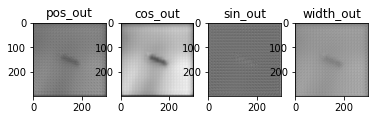

In [3]:
#看一下是否能够给出一个相对合理的预测
num = 20

plt.subplot(141)
plt.title('pos_out')
plt.imshow(pos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(142)
plt.title('cos_out')
plt.imshow(cos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(143)
plt.title('sin_out')
plt.imshow(sin[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(144)
plt.title('width_out')
plt.imshow(width[num][0].data.numpy(),cmap=plt.cm.gray)
plt.show()
#看起来还不错，下面开始数据的读取和反求

In [4]:
print(pos.shape)
print(cos.shape)
print(sin.shape)
print(width.shape)

torch.Size([32, 1, 300, 300])
torch.Size([32, 1, 300, 300])
torch.Size([32, 1, 300, 300])
torch.Size([32, 1, 300, 300])


In [5]:
q_img = pos.data.numpy().squeeze()
ang_img = (torch.atan2(sin, cos) / 2.0).data.numpy().squeeze()
width_img = width.data.numpy().squeeze()

In [6]:
#squeeze的作用通过前后的shape就可以看出来，对于单通道的图像，可视化以及后面计算的时候是不要需要第三个维度的，所以去掉了
print(q_img.shape)
print(ang_img.shape)
print(width_img.shape)

(32, 300, 300)
(32, 300, 300)
(32, 300, 300)


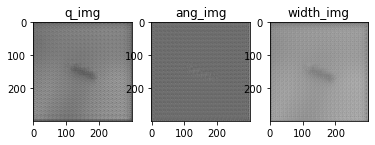

In [7]:
#可视化一下看看效果

num = 20

plt.subplot(131)
plt.title('q_img')
plt.imshow(q_img[num],cmap=plt.cm.gray)
plt.subplot(132)
plt.title('ang_img')
plt.imshow(ang_img[num],cmap=plt.cm.gray)
plt.subplot(133)
plt.title('width_img')
plt.imshow(width_img[num],cmap=plt.cm.gray)
plt.show()

在真正计算之前，还需要进行一个高斯滤波，原因论文中已经说过了，前面与已经可视化了滤波之前的效果，后面滤波一下，然后再看效果

In [8]:
from skimage.filters import gaussian
q_img_g = gaussian(q_img, 2.0, preserve_range=True)
ang_img_g = gaussian(ang_img, 2.0, preserve_range=True)
width_img_g = gaussian(width_img, 1.0, preserve_range=True)

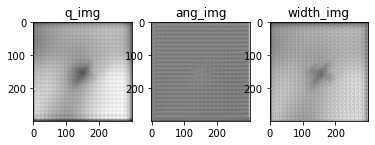

In [9]:
#可视化一下看看效果

plt.subplot(131)
plt.title('q_img')
plt.imshow(q_img_g[num],cmap=plt.cm.gray)
plt.subplot(132)
plt.title('ang_img')
plt.imshow(ang_img_g[num],cmap=plt.cm.gray)
plt.subplot(133)
plt.title('width_img')
plt.imshow(width_img_g[num],cmap=plt.cm.gray)
plt.show()

为什么会出现十字的效果？？？新出现的垂直于原始走向的那部分明显不符合要求啊。

测试一下这个函数看看是怎么回事

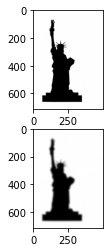

In [10]:
import cv2

img = cv2.imread('../images/test_guassian.jpg',0)
img_guassian = gaussian(img, 5.0, preserve_range=True)

plt.subplot(211)
plt.imshow(img,cmap=plt.cm.gray)
plt.subplot(212)
plt.imshow(img_guassian,cmap=plt.cm.gray)
plt.show()

挺好的啊，在这个图像上面就是简单地模糊了一下，为什么在原来的图像上却出现了十字。

下面用opencv的函数试一下高斯滤波

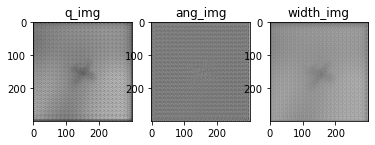

In [11]:
import cv2

q_img = cv2.GaussianBlur(q_img,(3,3),0)
ang_img = cv2.GaussianBlur(ang_img,(3,3),0)
width_img = cv2.GaussianBlur(width_img,(3,3),0)

plt.subplot(131)
plt.title('q_img')
plt.imshow(q_img[num],cmap=plt.cm.gray)
plt.subplot(132)
plt.title('ang_img')
plt.imshow(ang_img[num],cmap=plt.cm.gray)
plt.subplot(133)
plt.title('width_img')
plt.imshow(width_img[num],cmap=plt.cm.gray)
plt.show()

同样出现了类似的十字，说明应该是img的问题而不是函数的问题，那么下面用一下ggcnn原始的网络输出试一下，通过载入一个训练好的模型，用它计算输出来实现。

In [13]:
#载入训练好的模型
net = torch.load('trained_model')

D:\ProgramData\Anaconda3\envs\gg-cnn\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'ggcnn.GGCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


这模型载入不进来，查了一下是torch本身的问题，这模型要想成功载入，程序必须和原始生成它的程序在同一目录下才行，所以我程序就拿不过来了，直接就在原始的项目文件夹下进行了测试，结果发现还是有十字，下面把结果图放上来。
![cross_1](../images/cross_1.png)
![cross_2](../images/cross_2.png)
![cross_3](../images/cross_3.png)
![cross_4](../images/cross_4.png)
![cross_5](../images/cross_5.png)

那么现在需要明确的问题有两个，解决了这两个问题就可以顺利继续向下进行了
- 是什么原因导致了对一个长条状的图像进行滤波后产生了十字型的结果？
- 这个结果是否会像我直观想象得那样，严重影响训练结果？

第一个问题的排查和分析，我猜想可能是由于这数据仅仅是映射所得矩阵而已，并非标准的图像文件，以q_img为例，如果把它的原始数据打印出来，会发现是由很多小数乃至负数组成的矩阵，但真正的像素点的值肯定是正整数才行，这样的图像用高斯滤波处理的话，虽然计算上看似没什么问题，但是不知道中间做了什么样的处理，是不是这些对非正整数的处理导致了十字的出现？
下面设计了两个实验来对其进行研究：
- 1.在进行高斯滤波之前把q_img进行取绝对值和取整处理
- 2.直接将生成的q_img保存为图片，然后再读取进来处理，看可不可以，因为处理其他网络上下载的图片时没有这问题

第一个实验的测试要载入模型，所以源代码没办法放在这，但经过测试还是不行的。
第二个实验的测试如下，可以看到没有十字了。

In [14]:
img = cv2.imread('../images/img.png',0)
img_g = gaussian(img, 5.0, preserve_range=True)

In [15]:
img

array([[ 5,  5,  5, ...,  3,  6,  4],
       [ 5,  2,  6, ...,  3,  0,  2],
       [ 4,  4,  4, ...,  0,  4,  0],
       ...,
       [ 9,  7,  5, ..., 16, 11,  9],
       [ 7,  3,  5, ..., 13, 13, 14],
       [ 7,  7,  5, ..., 16, 13, 20]], dtype=uint8)

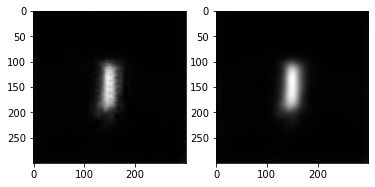

In [16]:
plt.subplot(121)
plt.imshow(img,cmap = plt.cm.gray)
plt.subplot(122)
plt.imshow(img_g,cmap = plt.cm.gray)

plt.show()

然后经过一段时间的仔细比对，我终于发现了问题的所在，就是batch_size的问题，前面的处理都是一批一批的，一般32个，但是到了高斯滤波这里，一次就只能处理一个，这函数好像就是这么设计的，所以一次给他输入了那么多的样本之后它搅在一起了，混乱了，出现的其他部位是来自其他样本的，验证的时候把batch_size设为1就行了。ggcnn里面就是在这么做的，我当时没注意，直接写的32，所以导致了后面这些错误，耽误了一天的时间，归根结底的原因还是粗心大意想当然了，下意识地以为gaussian函数可以批处理，压根就没考虑这块的内容，下面重写validate这块的内容

## 2.标准的确定
### 2.1 IoU的计算
全称Intersection over Union
![IoU计算示意图](../images/iou.png)

计算IoU程序的设计思路可以参考：https://blog.csdn.net/u014061630/article/details/82818112